# SVM ECHR prediction demo
<br>
Predicting the outcome of ECHR Judgments relating to Article 6 (Right to a fair trial)
<br> 
<b>Target Variable</b>: violation (1) or non-violation (0)
<br> 
<b>Model</b>: Linear SVM
<br> 
<b>Features</b>: n-grams from Judgment document sections
<br>


Judgment sections considered: 
<ul>
    <li>procedure+facts
        <ul>
   <li>procedure
   <li>facts
       <ul>
 <li> circumstances
   <li> relevant law
       </ul>
       </ul>
   <li>law
   <li>verdict
</ul>

In [5]:
#Imports
import numpy as np
from numpy import inf
import pandas as pd
import json
import pickle

from tqdm import tnrange, tqdm_notebook


from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#sns.set_palette("Set2")
%matplotlib inline


from src import functions 
classif = functions.classification()

In [18]:
#Example of the feature matrix used to train the models.
path = "./data/features/train_ngram_2000_6_procedure_english.csv"
train = pd.read_csv(path)
train[train['absence']+train['writing'] > 0].head(10)

,absence,access,access court,accordance,accordance article,accordance article convention,accordance president,accordance president decision,accordance president decision hearing,accordance provisions,...,writing,writing observations,written,written observations,written observations rule,written procedure,written procedure article,written procedure article convention,zaytsev,target
27,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
37,0.5,0.0,0.0,0.333333,0.5,0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.666667,0.0,0.0,0.5,0.5,0.0,0.0,1
51,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.333333,0.0,0.0,0.5,0.5,0.5,0.0,1
92,0.0,0.5,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
96,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.333333,0.5,1.0,0.0,0.0,0.0,0.0,1
99,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
109,0.0,0.5,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
123,0.5,0.5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
143,0.5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1
155,0.5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1


## Data Exploration 

In [34]:
#Full list of N-grams
ngrams = train.columns
for n in ngrams[0:10]:
    print(n)
print("...")

able
able to
about
about the
above
absence
absence of
accepted
access
access to
...


Some interesting n-grams:
<ul>
    <li> alleged violation
    <li> alleged right
   <li> applicant lawyer
    <li> application russian
     <li> application united kingdom
    <li> criminal
</ul>
    

## Training SVM

In [22]:
def k_fold(filename,C=0.1,cv = 10,kernel='linear'):
    """
    Returns k_fold accuracy for a given feature set
    """
    
    path = "./data/features/{}.csv"
    
    train = pd.read_csv(path.format("train_"+filename))
    
    X = train.drop(columns='target')
    y = train['target']
    
    model = SVC(kernel=kernel, C=C)
    scores = cross_val_score(model, X, y, cv=cv)
    accuracy = scores.mean()
    sd = scores.std()
    
    return accuracy

In [25]:
#Train the model using all section variations

section = ['both', 'procedure', 'facts', 'circumstances', 'relevant']

print("K-fold cross validation accuracy")

for s in section:
    accuracy = k_fold('ngram_2000_6_{}_none'.format(s))
    
    label = s
    if label == 'both': label = 'procedure+facts'
    if label == 'relevant': label = 'relevant law'
    print("{}: {}".format(label,np.round(accuracy,4)))

K-fold cross validation accuracy
procedure+facts: 0.7292
procedure: 0.6943
facts: 0.7173
circumstances: 0.6914
relevant law: 0.6794


In [75]:
def autolabel(rects):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = round(rect.get_height(),4)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha='center', va='bottom',
                   fontsize = 12)

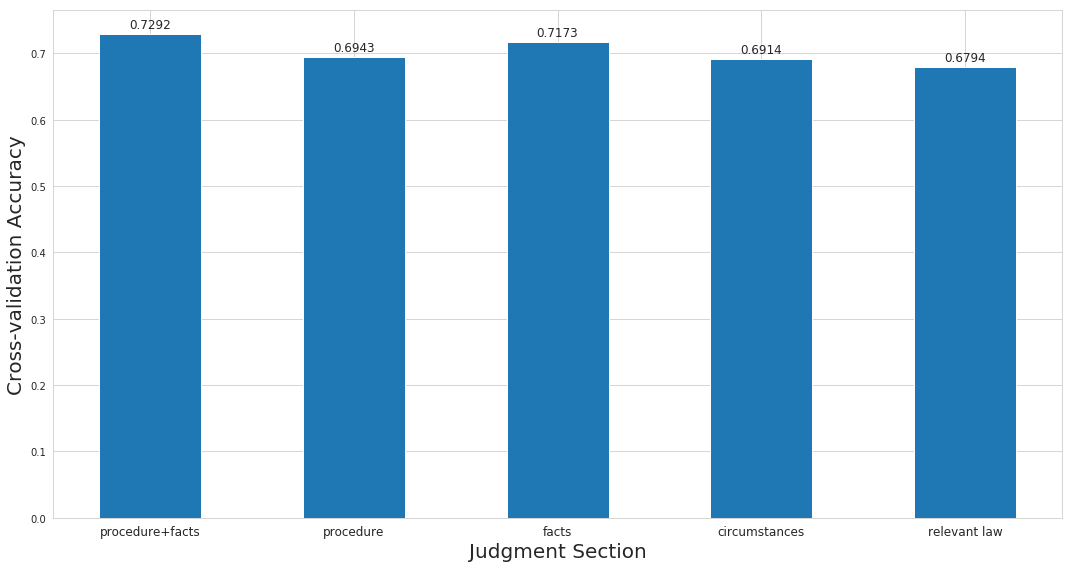

In [76]:
#Visualise training results
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15,8))


train_accuracy = [0.7292,0.6943,0.7173,0.6914,0.6794]
labels = ['procedure+facts', 'procedure', 'facts', 'circumstances', 'relevant law']
x = np.arange(len(labels)) 

width = 0.5
rec = plt.bar(x = x,height = train_accuracy,width=width)
autolabel(rec)
ax.set_xlabel('Judgment Section', fontsize = 20)
ax.set_ylabel('Cross-validation Accuracy', fontsize = 20)
plt.xticks(x)
ax.set_xticklabels(labels,fontsize=12)
#plt.legend(fontsize=14,bbox_to_anchor=(1, 1))
plt.tight_layout()



## Testing
procedure+facts produced the highest training accuracy. We retrain this model on the entire training set and test it on the test set.

In [26]:
#Train and test the model on test set
path = "./data/features/{}.csv"
filename = 'ngram_2000_6_both_none'

train = pd.read_csv(path.format("train_"+filename))
test = pd.read_csv(path.format("test_"+filename))


X_train = train.drop(columns='target')
y_train = train['target']

X_test= test.drop(columns='target')
y_test = test['target'] 

model = SVC(kernel='linear', C=0.1).fit(X_train,y_train)

#Get test predictions
predictions = model.predict(X_test)



In [27]:
# The model acheived an accuracy of 78.3% on the test set
test_accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy: {}'.format(np.round(test_accuracy,4)))

Test Accuracy: 0.783


In [29]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.32      0.68      0.44        56
          1       0.95      0.80      0.87       391

avg / total       0.87      0.78      0.81       447



In [30]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[ 38  18]
 [ 79 312]]


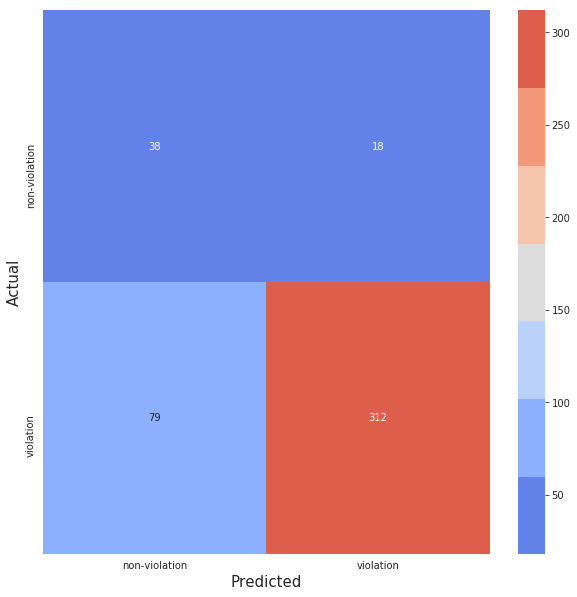

In [31]:
#Visualise confusion matrix
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(10,10))

sns.heatmap(cm, annot=True,fmt='.4g',cmap =sns.color_palette("coolwarm", 7))

ax.xaxis.set_ticklabels(['non-violation', 'violation']); 
ax.yaxis.set_ticklabels(['non-violation', 'violation']);

ax.set_xlabel('Predicted',fontsize=15);
ax.set_ylabel('Actual',fontsize=15); 